# Exercise 6 - EKF Localization

In this assignment you need to implement an EKF algorithm for localizing a robot in a given landmark map. 
The data for this exercise is recorded on a differential drive robot equipped with a sensor able to detect the distance and the angle of landmarks (e.g., beacons). The figure below visualizes the landmark map and the actual trajectory (ground truth) taken by the robot.

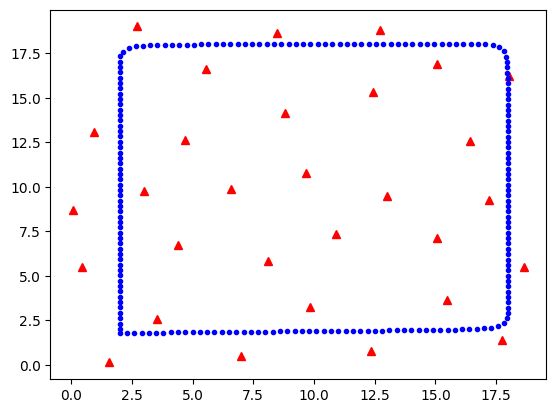

In [55]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import ex6 as ex
%matplotlib inline

# read dataset
data = pickle.load(open("dataset_2d_landmarks.p", "rb"))

# get landmark coordinates 
M = data['M']

# get ground truth trajectory
gt_traj = data['gt']

# show map
plt.figure(1)
plt.plot(M[:,0], M[:,1], '^r')

# show ground truth trajectory
for i in range(0,len(gt_traj),10):
    plt.plot(gt_traj[i][0],gt_traj[i][1], '.b')


The following data is provided in `data`:

- *M* is the map of the environment where the robot must localize
- *odom* is the noisy odometry readings observed by the robot during navigation in the form: $\hat{x}_t,\hat{y}_t, \hat{\theta}_t$ in the odometry frame
- *gt* is the ground truth trajectory (poses in the map frame), you may want to use it for checking your results
- *z* are the sensor measurements

Each measurement $z_t$ contains a set of observed landmarks $[\rho_i; \phi_i; id_i]$, where $\rho_i$ is the measured distance, $\phi_i$ is the measured angle, and $id_i$ is the id of the landmark.

You can access the `data` as follows:

In [56]:
# get odomety at timestamp 10
odom_10 = data['odom'][10]
print("Odom at step 10 is: \n",odom_10)

# get observation at timestamp 10
z_10 = data['z'][10]
print("Observation at step 10 is: \n",z_10)

Odom at step 10 is: 
 [ 0.3449921   0.00058428 -0.02110238]
Observation at step 10 is: 
 [[ 2.1793557   1.27533718  3.5604415 ]
 [ 2.92652148 -1.4372858   0.4519207 ]
 [ 4.         11.         14.        ]]


## 6.1 Prediction [3.0]

The `ekf_predict` function computes a prediction about the robot's pose after moving by using the odometry motion model.

It takes as input:

- the current belief about the pose of the robot represented as a Gaussian distribution $\mathcal{N}(\mu_t,\Sigma_t)$ 
- the odometry readings $u_t$

The output is a prediction about the robot's pose $\mathcal{N}(\overline{\mu}_{t+1},\overline{\Sigma}_{t+1})$.

You can use your implementation of the `inverse_motion_model` function from Exercise 3 to compute the $u_t = [\delta_{rot1}, \delta_{trans}, \delta_{rot2}]$  from the odometry information.

Implement the `ekf_predict` function and verify that it is correct for some test input. 

In [57]:
def ekf_predict(mu, sigma, u_t, alpha):
        
    '''
    Parameters:
    mu : current belief mean [x, y, theta]
    sigma : array (3, 3)
        current belief covariance matrix
    u_t : control input [delta_rot1, delta_trans, delta_rot2]
    alpha : motion noise parameters [alpha1, alpha2, alpha3, alpha4]

    Returns:
    mu_bar : predicted belief mean
    sigma_bar : array (3, 3)
            predicted belief covariance
    '''
    x, y, theta=mu
    delta_rot1, delta_trans, delta_rot2 = u_t    

    # getting new pose belief
    x_new=x+delta_trans*np.cos(theta+delta_rot1)
    y_new=y+delta_trans*np.sin(theta+delta_rot1)
    theta_new=theta+delta_rot1+delta_rot2
    theta_new=np.arctan2(np.sin(theta_new), np.cos(theta_new)) # to make range from -pi/2 to pi/2

    mu_bar=np.array([x_new, y_new, theta_new]) # the mean of estimated pose, we will return this 

    # compute jacobian of new state wrt state (G)
    G = np.array([
        [1, 0, -delta_trans * np.sin(theta + delta_rot1)],
        [0, 1,  delta_trans * np.cos(theta + delta_rot1)],
        [0, 0,  1]])
    
    # compute noise uncertainity matrix (M)
    M=np.array([
        [(alpha[0]*delta_rot1**2)+(alpha[1]*delta_trans**2), 0, 0],
        [0, (alpha[2]*delta_trans**2)+(alpha[3]*(delta_rot1**2+delta_rot2**2)), 0],
        [0, 0, (alpha[0]*delta_rot2**2)+(alpha[1]*delta_trans**2)]])

    
    # compute jacobian of new state wrt control commands (V)
    V=np.array([
        [-delta_trans*np.sin(theta+delta_rot1), np.cos(theta+delta_rot1), 0],
        [delta_trans*np.cos(theta+delta_rot1), np.sin(theta+delta_rot1), 0],
        [1, 0, 1]
    ])

    # transform noise to state space (R)
    R=V@M@ V.T

    # now compute the total new predicted uncertainity 
    sigma_bar=G@sigma@G.T+R

    return mu_bar, sigma_bar
    



In [58]:
mu=np.array([0.0, 0.0, 0.0])  
sigma=np.eye(3)*0.01  

# control from inverse_motion_model
u_t=np.array([0.925, 5.0, -0.925])  # [delta_rot1, delta_trans, delta_rot2]

# noise parameters
alpha=np.array([0.1, 0.1, 0.01, 0.01])

# Predict
mu_bar,sigma_bar=ekf_predict(mu, sigma, u_t, alpha)

print(f"the mean of expected pose is {mu_bar}, and the covariance is {sigma_bar}")

the mean of expected pose is [3.00917296 3.99310382 0.        ], and the covariance is [[ 41.49267708 -31.05973905 -10.36435052]
 [-31.05973905  23.68349792   7.8104965 ]
 [-10.36435052   7.8104965    5.181125  ]]


## 6.2 Correction [3.0]

The `ekf_correct` implements the correction step of the EKF that corrects the prediction according to the sensor measurements.

It takes as input:

- the current prediction about the pose of the robot represented as a Gaussian distribution $\mathcal{N}(\overline{\mu}_{t+1},\overline{\Sigma}_{t+1})$
- the sensor measurements $z_t$

The output is new belief about the robot's pose $\mathcal{N}({\mu}_{t+1},{\Sigma}_{t+1})$.

Implement the `ekf_correct` function and verify that it is correct for some test input

In [59]:
def measurement_model(mu_bar, landmark_id, M):
    """
    Compute expected measurement for a landmark
    
    Parameters:
    -----------
    mu_bar : numpy array (3,)
        Predicted robot pose [x, y, theta]
    landmark_id : int
        ID of the landmark being observed
    M : numpy array (N, 2)
        Map of landmark positions [[x1, y1], [x2, y2], ...]
    
    Returns:
    --------
    z_hat : numpy array (2,)
        Expected measurement [rho, phi] (range, bearing)
    """
       
    x, y, theta=mu_bar
    x_l, y_l=M[landmark_id]
    
    # expected range -> distance only
    rho=np.sqrt((x_l-x)**2+(y_l-y)**2)

    # expected bearing -> angle relative to robot heading
    phi=np.arctan2((y_l-y), (x_l-x))-theta
    phi=np.arctan2(np.sin(phi), np.cos(phi)) # normalized

    z_hat=np.array([rho, phi])

    return z_hat

In [60]:
def measurement_jacobian(mu, landmark_id, M):
    """
    Jacobian of measurement model h w.r.t. state
    
    H = dh/dx = d[rho, phi]/d[x, y, theta]
    """

    x, y, theta=mu
    x_l, y_l=M[landmark_id]

    dx=x_l-x
    dy=y_l-y
    q=dx**2+dy**2
    dist=np.sqrt(q)

    H=np.array([
        [-dx/dist, -dy/dist, 0],
        [dy/q, -dx/q, -1]
    ])

    return H


In [61]:
def ekf_correct(mu_bar,sigma_bar, z_t, M, Q):
    """
    EKF correction step
    mu_bar : predicted mean [x, y, theta]
    sigma_bar : predicted covariance (3*3)
    z_t : sensor measurements-list of [rho_i, phi_i, id_i]
    M : landmark map
    Q : sensor noise covariance (2*2) for [rho, phi]
    """

    mu=mu_bar.copy()
    sigma=sigma_bar.copy()

    for measurement in z_t:
        rho_measured, phi_measured, landmark_id=measurement

        z_hat=measurement_model(mu, landmark_id, M) # you will get rho expected and phi expected from this function

        y=np.array([rho_measured, phi_measured])-z_hat # difference between the measured (real) and expected observations
        y[1]=np.arctan2(np.sin(y[1]),np.cos(y[1])) # normalize again

        # compute the jacobian of observations wrt states (H)
        H=measurement_jacobian(mu, landmark_id, M)

        # compute the innovation covariance matrix (S)
        S=H@sigma@H.T+Q

        # compute kalman gain (K)
        K=sigma@H.T@np.linalg.inv(S)

        #update state and convariance
        mu=mu_bar+K@y
        sigma=(np.identity(3)-K@H)@sigma

    return mu, sigma


In [62]:
# initial state
mu_prev=np.array([0.0, 0.0, 0.0])
sigma_prev=np.eye(3)*0.1

# control input
u_t=np.array([np.radians(45), 5.0, np.radians(-15)])

# motion noise
alpha=np.array([0.01, 0.01, 0.001, 0.001])

# predict
mu_bar, sigma_bar=ekf_predict(mu_prev, sigma_prev, u_t, alpha)

print("AFTER PREDICTION")
print("mu_bar:", mu_bar)
print("sigma_bar:")
print(sigma_bar)


M=np.array([[5.0, 5.0], [10.0, 3.0], [8.0, 9.0], [2.0, 8.0]])
z_t=[[2.83, 0.26, 0], [7.28, -0.09, 1]]
Q=np.array([[0.1, 0.0], [0.0, 0.05]])

mu, sigma=ekf_correct(mu_bar, sigma_bar, z_t, M, Q)

print("\nAFTER CORRECTION")
print("mu:", mu)
print("sigma:")
print(sigma)

AFTER PREDICTION
mu_bar: [3.53553391 3.53553391 0.52359878]
sigma_bar:
[[ 4.56494898 -4.43926359 -1.25924582]
 [-4.43926359  4.56494898  1.25924582]
 [-1.25924582  1.25924582  0.60685389]]

AFTER CORRECTION
mu: [3.06388208 3.96697483 0.15289661]
sigma:
[[ 0.06691061 -0.05027145  0.0199714 ]
 [-0.05027145  0.13827259 -0.03612702]
 [ 0.0199714  -0.03612702  0.03316514]]


## 6.3 Localization [3.0]

Once you complete all the above functions, implement the main procedure of EKF localization `ekf_localization` which recursively estimates the pose of the robot using the odometry data and the sensor measurements.

Assume the initial belief at time $t=0$ is:

- $\mu = [2, 2, \pi/2]'$
- $
\Sigma = \left(\begin{array}{cc} 
1 & 0 & 0\\
0 & 1 & 0 \\
0 & 0 & \pi/3
\end{array}\right)
$ 
            
The process noise $R$ and measurement noise $Q$ are defined as:
- $R = \left(\begin{array}{cc} 
\sigma_x^2 & 0 & 0 \\
0 & \sigma_y^2 & 0 \\
0 & 0 &  \sigma_{theta}^2
\end{array}\right)
$

with $\sigma_x = 0.25$ meters, $\sigma_y = 0.25$ meters and $\sigma_theta = 10$ degrees. 
 
- $Q = 
\left(\begin{array}{cc} 
\sigma_r^2 & 0 \\
0 & \sigma_{phi}^2 
\end{array}\right)
$

with $\sigma_r = 0.10$ meters, $\sigma_{phi} = 5$ degrees. 

Plot the belief about the position of the robot after the sequence of odometry readings and sensor measurements provided in `data` by using the `plot_state` function.

In [63]:
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
from matplotlib.patches import Ellipse


def plot_state(mu, S, M):

    # initialize figure
    ax = plt.gca()
    ax.set_xlim([np.min(M[:, 0]) - 2, np.max(M[:, 0]) + 2])
    ax.set_ylim([np.min(M[:, 1]) - 2, np.max(M[:, 1]) + 2])
    plt.plot(M[:, 0], M[:, 1], '^r')
    plt.title('EKF Localization')

    # visualize result
    plt.plot(mu[0], mu[1], '.b')
    plot_2dcov(mu, S)
    plt.draw()
    plt.pause(0.01)


def plot_2dcov(mu, cov):

    # covariance only in x,y
    d, v = np.linalg.eig(cov[:-1, :-1])

    # ellipse orientation
    a = np.sqrt(d[0])
    b = np.sqrt(d[1])

    # compute ellipse orientation
    if (v[0, 0] == 0):
        theta = np.pi / 2
    else:
        theta = np.arctan2(v[0, 1], v[0, 0])

    # create an ellipse
    ellipse = Ellipse((mu[0], mu[1]),
                      width=a * 2,
                      height=b * 2,
                      angle=np.rad2deg(theta),
                      edgecolor='blue',
                      alpha=0.3)

    ax = plt.gca()

    return ax.add_patch(ellipse)


def wrapToPi(theta):
    while theta < -np.pi:
        theta = theta + 2 * np.pi
    while theta > np.pi:
        theta = theta - 2 * np.pi
    return theta


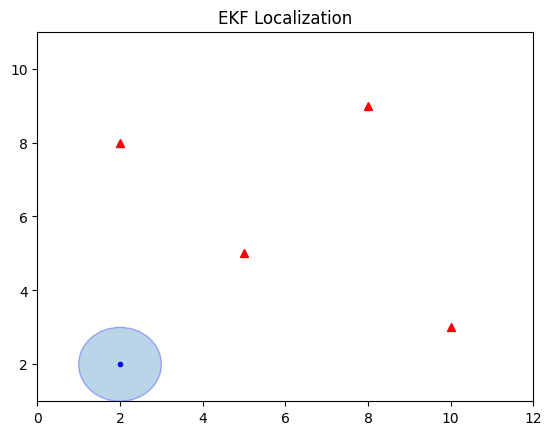

In [64]:
# 3x3 process noise
sigma_x = 0.25  # [m]
sigma_y = 0.25  # [m]
sigma_theta = np.deg2rad(10)  # [rad]
R = np.diag(np.array([sigma_x, sigma_y, sigma_theta])**2)

# 2x2 observation noise
sigma_r = 0.1  # [m]
sigma_phi = np.deg2rad(5)  # [rad]
Q = np.diag(np.array([sigma_r, sigma_phi])**2)

# initial state
mu = np.array([2, 2, np.pi/2]) 
S = np.array([[1, 0, 0],[0, 1, 0], [0, 0, np.pi/3]])

# visualize
plt.figure()
plot_state(mu, S, M)


In [ ]:
def ekf_localization(mu_initial, sigma_initial, alpha, data, R, Q):
    """
    main EKF localization loop
    
    Parameters:
    - data: sequence of odometry and sensor measurements
    - mu_initial: initial state [x, y, theta]
    - sigma_initial: initial covariance matrix (3*3)
    - R: process noise covariance (3*3)
    - Q: measurement noise covariance (2*2)
    """

    mu=mu_initial.copy()
    sigma=sigma_initial.copy()

    plt.ion()
    plt.figure(figsize=(10, 10))

    for t in range(len(data['odom'])):
        # get odomety at timestamp t
        u_t=data['odom'][t]

        # get observation at timestamp t
        measurements=data['z'][t]
        num_measurements=measurements

        mu_pred, sigma_pred=ekf_predict(mu, sigma, u_t, alpha) # predicted

        mu=mu_pred.copy()
        sigma=sigma_pred.copy()

        # correction step now
        for measurement in measurements:
            mu, sigma= ekf_correct(mu, sigma, measurement, M, Q)

        plot_state(mu, sigma, M)
        
    
    plt.show()
    return mu, sigma

    